In [1]:
#!/bin/bash
!kaggle datasets download msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 73% 44.0M/60.3M [00:00<00:00, 75.0MB/s]
100% 60.3M/60.3M [00:00<00:00, 94.7MB/s]


In [2]:
!unzip fer2013

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [3]:
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import random
import keras
from tensorflow.keras.utils import image_dataset_from_directory
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout,Flatten,Conv2D,MaxPooling2D
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# **Data Reading and Augmentation**


In [4]:
img_height = 48
img_width = 48
batch_size = 32

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rotation_range = 15,
    width_shift_range = 10,
    height_shift_range = 10,
    validation_split = 0.2
    )

In [6]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [7]:
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    subset = 'training'
    )

Found 22968 images belonging to 7 classes.


In [8]:
validation_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    subset = 'validation'
    )

Found 5741 images belonging to 7 classes.


In [9]:
test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
    )

Found 7178 images belonging to 7 classes.


# **Exploring Random Images**

In [10]:
class_labels = list(train_generator.class_indices.keys())
print(class_labels)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [11]:
img, label = train_generator.__next__()

In [12]:
img.shape

(32, 48, 48, 1)

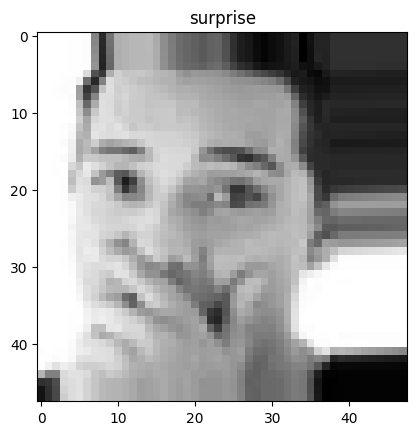

In [13]:
i = random.randint(0,(img.shape[0]-1))
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

# **Exploring Training set**

In [14]:
class_count = np.unique(train_generator.classes, return_counts=True)
print("Class",class_count[0])
print("Count",class_count[1])

Class [0 1 2 3 4 5 6]
Count [3196  349 3278 5772 3972 3864 2537]


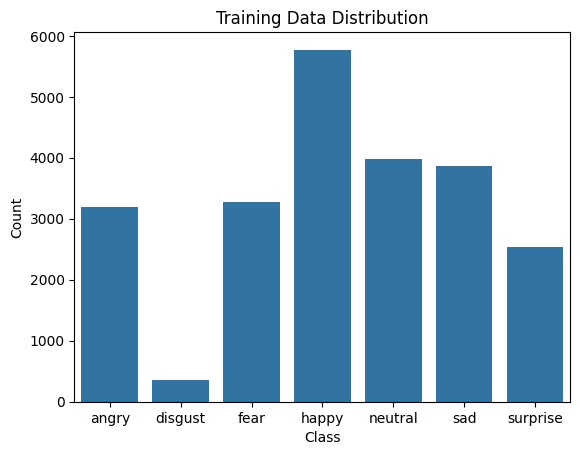

In [15]:
plt.figure()
sns.barplot(x=class_labels, y=class_count[1])
plt.title("Training Data Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# **Balancing Training Set**

In [16]:
class_weights = compute_class_weight(
                                    class_weight = "balanced",
                                    classes = np.unique(train_generator.classes),
                                    y = train_generator.classes
                                    )
dic_class_weights = dict(enumerate(class_weights))
dic_class_weights

{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.826068191627104,
 5: 0.8491570541259982,
 6: 1.2933160650937552}

# **bold text**

In [17]:
model = keras.models.Sequential([
    keras.Input(shape = (img_height, img_width, 1)),

    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=(48, 48, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.1),

    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same',),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.3),

    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(7, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 523,143 (2.00 MB)

 Trainable params: 523,079 (2.00 MB)

 Non-trainable params: 64 (256.00 B)

In [20]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                   min_delta = 0,
                                   patience = 10,
                                   verbose = 1,
                                   restore_best_weights = True)

In [21]:
check_point = keras.callbacks.ModelCheckpoint(filepath = "model.keras",
                                    monitor = 'val_loss',
                                    save_best_only = True,
                                    verbose = 1,
                                    mode = 'min')

In [22]:
model.fit(
    train_generator,
    epochs = 100,
    validation_data = validation_generator,
    batch_size = batch_size,
    callbacks = [early_stop,check_point],
    class_weight = dic_class_weights)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1472 - loss: 1.9458
Epoch 1: val_loss improved from inf to 1.90810, saving model to model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - accuracy: 0.1472 - loss: 1.9458 - val_accuracy: 0.2298 - val_loss: 1.9081
Epoch 2/100
715/718 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2058 - loss: 1.8877
Epoch 2: val_loss improved from 1.90810 to 1.87317, saving model to model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.2058 - loss: 1.8877 - val_accuracy: 0.1979 - val_loss: 1.8732
Epoch 3/100
715/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2188 - loss: 1.8319
Epoch 3: val_loss improved from 1.87317 to 1.80768, saving model to model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.2188 - loss: 1.8319 - val_accuracy: 0.2705 - val_loss: 1.8077
Epoch 4/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2448 - loss: 1.7794
Epoch 4: val_loss did not improve from 1.80768
718/718 ━━━━━━━━━━━━

In [23]:
scores = model.evaluate(test_generator)
print("Accuracy: %.2f%%" % (scores[1]*100))

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5026 - loss: 1.2594
Accuracy: 57.47%


In [24]:
scores

[1.1237177848815918, 0.5746726393699646]

In [25]:
pred_y = model.predict(test_generator)
pred_label = np.argmax(pred_y, axis=1)

true_label = test_generator.classes

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


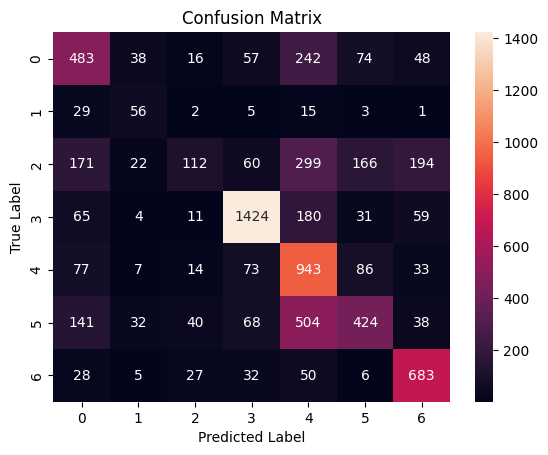

In [26]:
plt.figure()
sns.heatmap(confusion_matrix(true_label, pred_label), annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [27]:
print(classification_report(true_label, pred_label))

              precision    recall  f1-score   support

           0       0.49      0.50      0.49       958
           1       0.34      0.50      0.41       111
           2       0.50      0.11      0.18      1024
           3       0.83      0.80      0.82      1774
           4       0.42      0.76      0.54      1233
           5       0.54      0.34      0.42      1247
           6       0.65      0.82      0.72       831

    accuracy                           0.57      7178
   macro avg       0.54      0.55      0.51      7178
weighted avg       0.59      0.57      0.55      7178



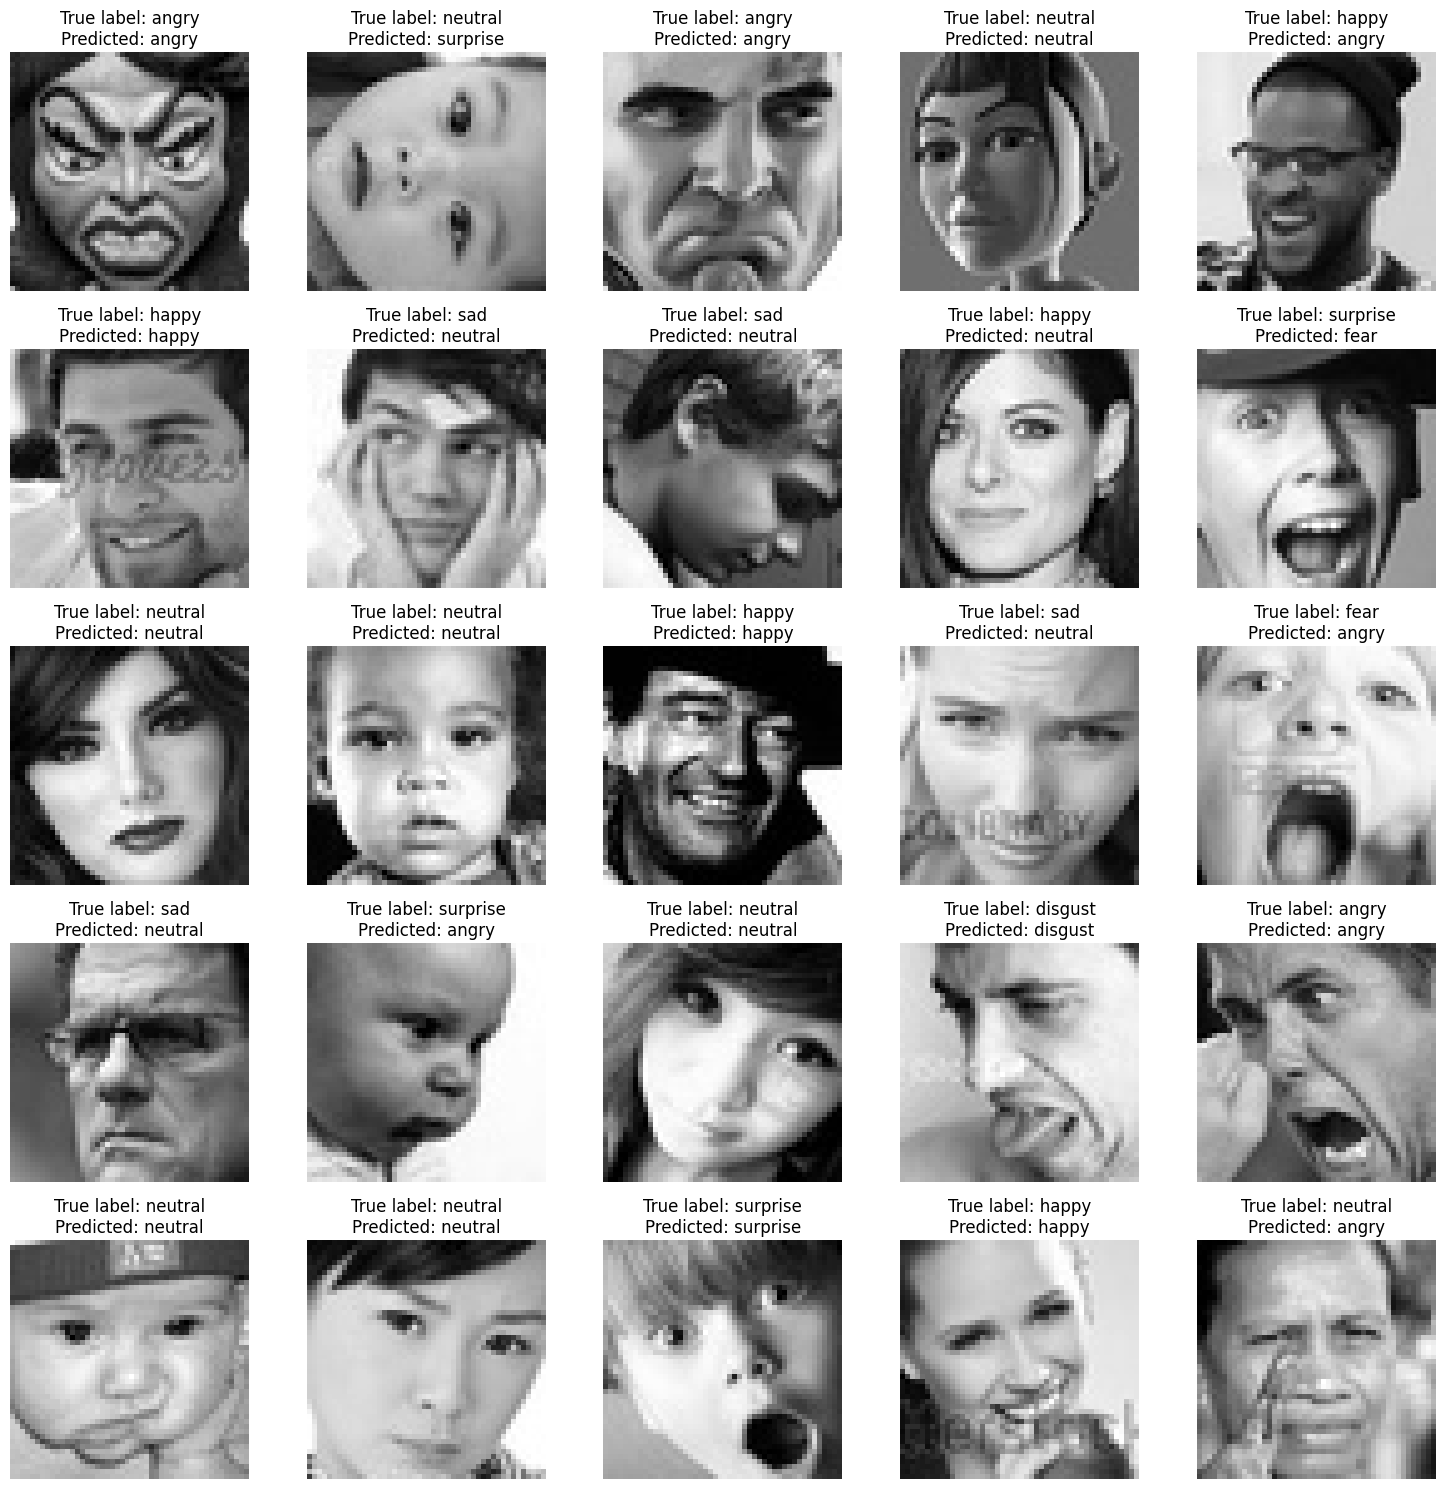

In [28]:
fig, axes = plt.subplots(ncols = 5, nrows = 5, figsize = (15, 15))
axes =axes.flatten()

for i in range(25):
    j = np.random.randint(test_generator.n)

    # take data
    batch_images, batch_labels = test_generator[j // batch_size]
    id_in_batch = j % batch_size
    image = batch_images[id_in_batch]
    label = batch_labels[id_in_batch].argmax()

    # show data
    axes[i].imshow(image, cmap = "gray")
    axes[i].set_title(f"True label: {class_labels[label]}\nPredicted: {class_labels[pred_label[j]]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()